# Honest AI for Food Security: A Prototypical Network Approach

### Authored By: Muttaqin Muzakkir
### Institution: Universitas Indonesia

---

## 1. Project Overview

This notebook documents the end-to-end development of our submission for the FIT Competition 2025. Our project addresses the critical challenge of **food security** by developing a novel deep learning model for accurate and, most importantly, **interpretable** plant disease classification.

**The Problem:** Standard AI models often act as "black boxes," providing predictions without explanation. This lack of transparency is a major barrier to adoption in high-stakes fields like agriculture.

**Our Solution:** We introduce an **"Honest AI"** built from scratch using a **Prototypical Network**. Instead of just classifying, our model learns a "platonic ideal" for each disease, offering a transparent and trustworthy diagnostic tool.

**Notebook Structure:**
* **Part 1: Exploratory Data Analysis (EDA):** We first dissect the PlantVillage dataset to understand its characteristics and justify our design choices.
* **Part 2: Prototypical Network Pipeline:** We then implement our from-scratch model, train it, and analyze its performance and interpretability.


In [1]:
# initialize all dependencies
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm import tqdm
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.transforms as T
import torchvision.datasets as datasets
import time
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score, classification_report
from PIL import Image
from torchinfo import summary

DATASET_PATH = "/kaggle/input/plantdisease/PlantVillage"

## Section 1: Exploratory Data Analysis (EDA) for Plant Disease Classification

**Objective:** The goal of this EDA is to thoroughly understand the PlantVillage dataset, identify its key characteristics and potential challenges, and use these insights to justify the design choices for our "Honest AI" Prototypical Network. 

We will investigate the following key questions:
1.  **Class Balance:** Is the dataset balanced, or will our model need special handling for under-represented classes?
2.  **Image Characteristics:** What are the physical properties (e.g., dimensions) of the images? This will inform our image preprocessing pipeline.
3.  **Visual Challenges & Augmentation Strategy:** What visual variations exist that could confuse a naive model, and how can we use data augmentation to build a robust and "honest" model that learns true features?


### 1.1 Loading images
This is an image dataset, so for easier analysis, we've converted the image paths to a dataframe with a corresponding label.

In [2]:
filepaths = []
labels = []
for class_name in os.listdir(DATASET_PATH):
    class_path = os.path.join(DATASET_PATH, class_name)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            filepaths.append(os.path.join(class_path, image_name))
            labels.append(class_name)

df = pd.DataFrame({'filepath': filepaths, 'label': labels})
print(f"Successfully loaded {len(df)} image paths.")

Successfully loaded 20639 image paths.


### 1.2 Class Distribution Analysis
Our investigation begins with the most fundamental question: is our dataset fair? A model trained on an imbalanced dataset will inherit its biases, leading to poor performance on under-represented classes. We visualize the class distribution to determine if we need to employ special techniques like class weighting.

Total number of classes: 15


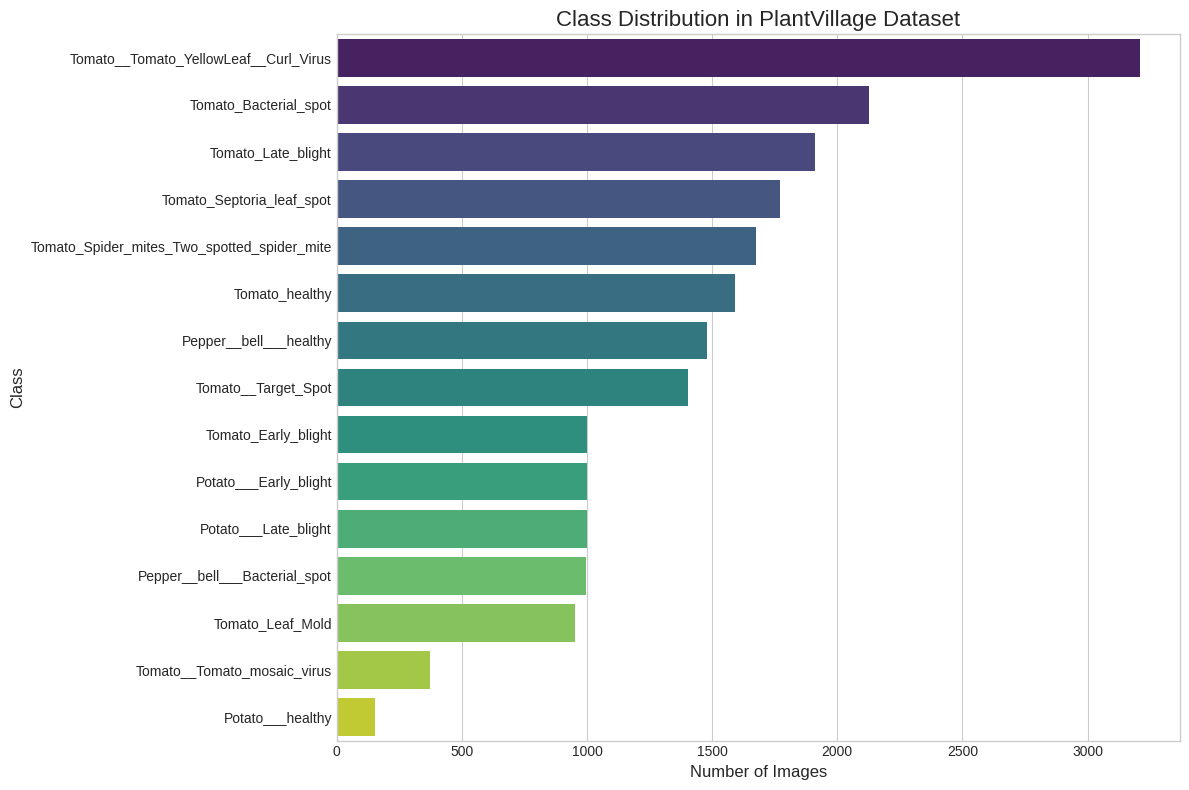

In [3]:
num_classes = df['label'].nunique()
print(f"Total number of classes: {num_classes}")

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))
ax = sns.countplot(y=df['label'], order=df['label'].value_counts().index, palette='viridis')
ax.set_title('Class Distribution in PlantVillage Dataset', fontsize=16)
ax.set_xlabel('Number of Images', fontsize=12)
ax.set_ylabel('Class', fontsize=12)
plt.tight_layout()
plt.savefig('eda_class_distribution.png')
plt.show()

### 1.3 Image Characteristics Analysis
Before we can process the images, we must first understand their physical properties. We analyze the dimensions of every image in the dataset to answer a critical question: are we dealing with a standardized set, or will we need to handle variable shapes and sizes? The histograms below reveal a clear and definitive answer.

From the data, the dataset is very uniform, with a single, dominant peak showing that virtually all images are 256x256 pixels. This is important since it simplifies our preprocessing pipeline immensely, as we do not need to account for varying aspect ratios. 

Analyzing image dimensions...


 16%|█▌        | 3298/20639 [00:26<03:47, 76.14it/s]

100%|██████████| 20639/20639 [02:52<00:00, 119.81it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


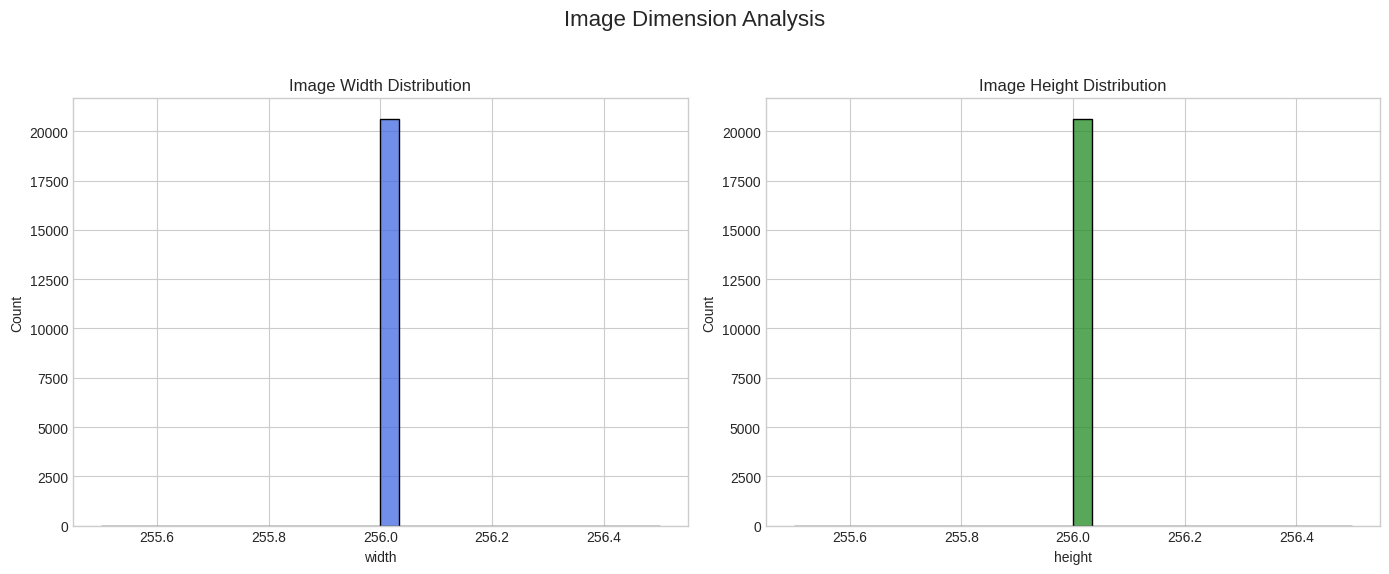

In [4]:
print("Analyzing image dimensions...")
dims = []
for filepath in tqdm(df['filepath']):
    try:
        with Image.open(filepath) as img:
            dims.append(img.size)
    except Exception as e:
        print(f"Warning: Could not read {filepath}. Error: {e}")

dims_df = pd.DataFrame(dims, columns=['width', 'height'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(dims_df['width'], ax=ax1, color='royalblue', bins=30)
ax1.set_title('Image Width Distribution')
sns.histplot(dims_df['height'], ax=ax2, color='forestgreen', bins=30)
ax2.set_title('Image Height Distribution')
plt.suptitle('Image Dimension Analysis', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('eda_dimension_analysis.png')
plt.show()

### 1.4. Visual Exploration and Augmentation Strategy
Here, we explore a few representative samples from different classes to identify:
- Visual noise
- Background artifacts
- Intra-class variability

Based on these observations, we design a **targeted augmentation strategy** to help the model focus on disease-relevant features rather than spurious correlations.

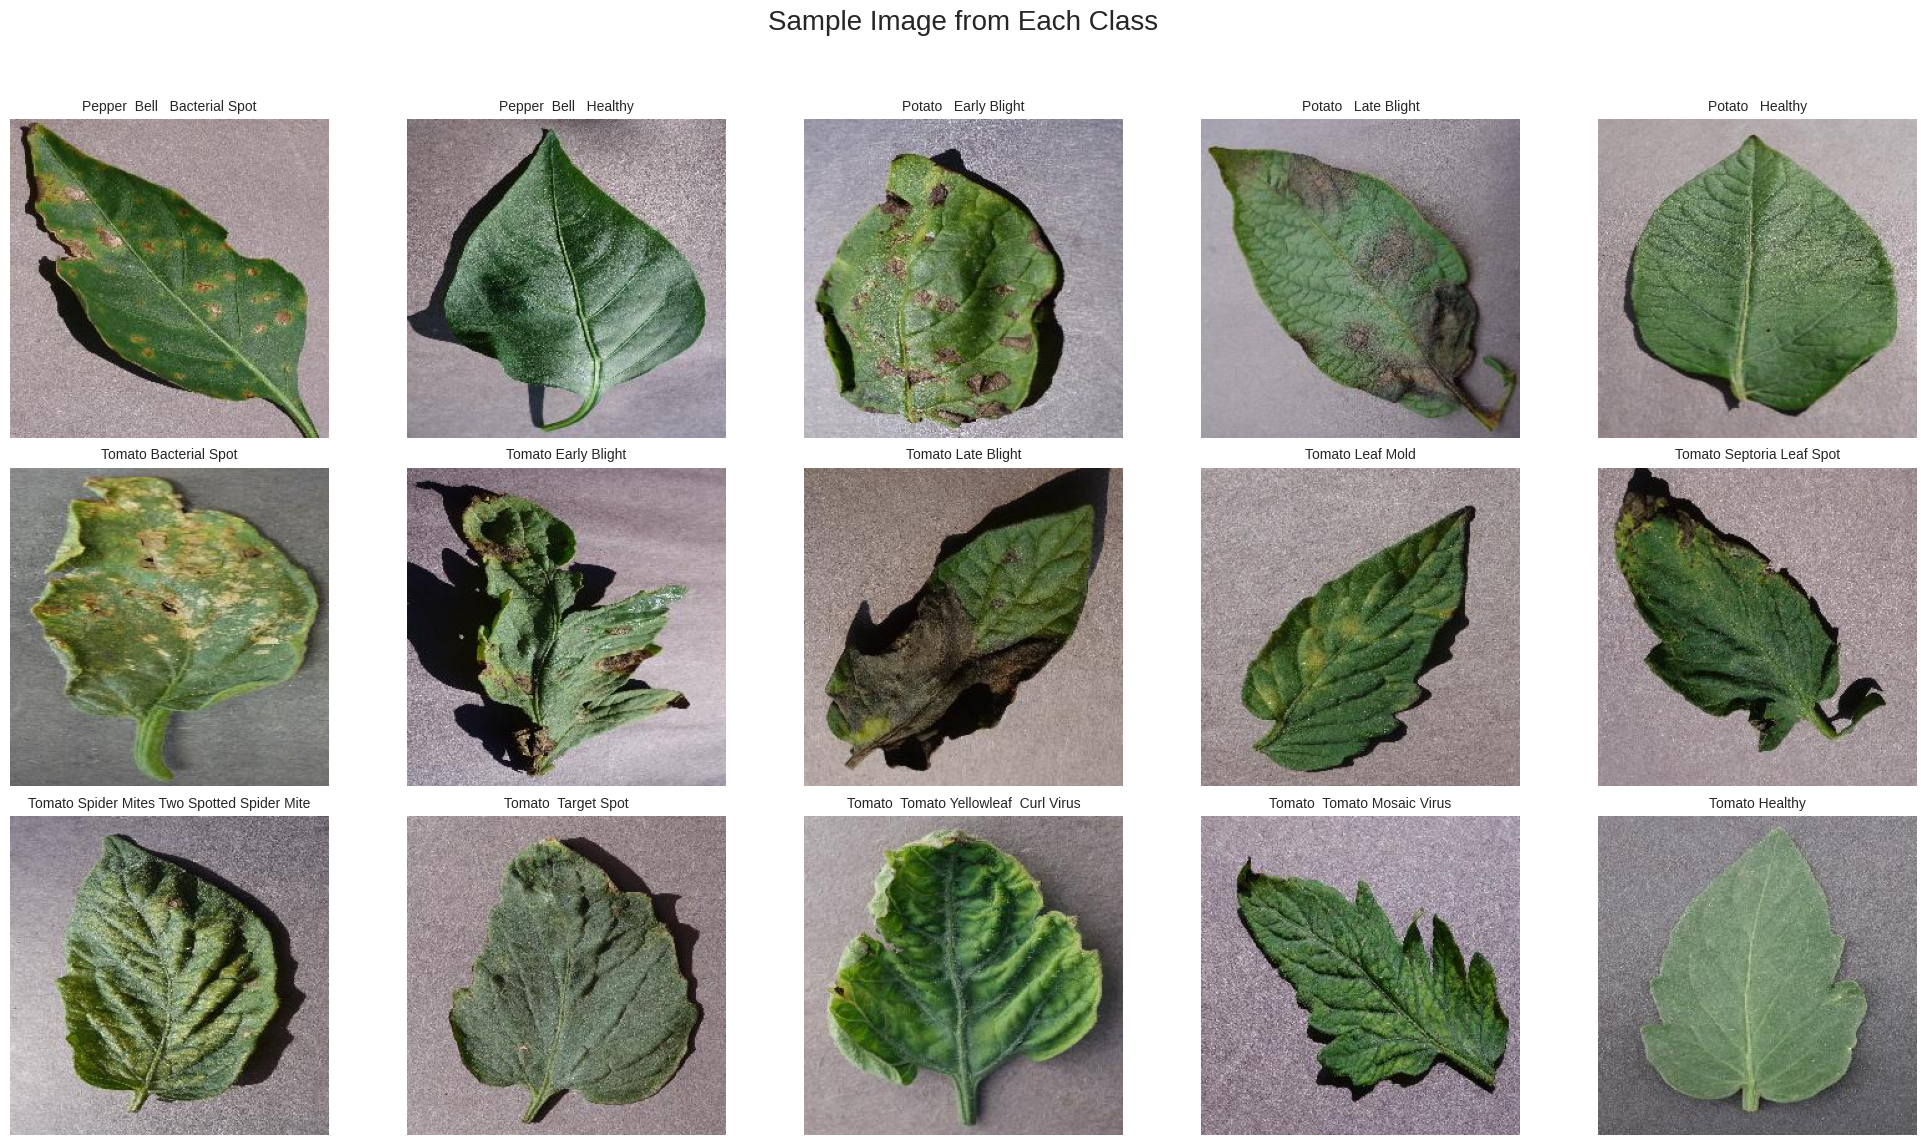

In [5]:
sample_df = df.groupby('label').sample(n=1).reset_index(drop=True)

fig, axes = plt.subplots(3, 5, figsize=(20, 12))
fig.suptitle('Sample Image from Each Class', fontsize=20)
for i, row in sample_df.iterrows():
    ax = axes[i // 5, i % 5]
    img = Image.open(row['filepath'])
    ax.imshow(img)
    ax.set_title(row['label'].replace('_', ' ').title(), fontsize=10)
    ax.axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('eda_sample_images.png')
plt.show()

### 1.5 Visualizing Image Transformations
To directly combat the visual inconsistencies identified in our EDA, we employ an aggressive data augmentation strategy during training. The following visualization demonstrates how our pipeline transforms a single, clean image into a variety of challenging new samples. By randomly altering the crop, orientation, and color profile of each image, we make it impossible for the model to learn superficial shortcuts. This process is fundamental to our methodology; it forces the model to learn the underlying, invariant features of each disease, which is the first and most critical step in building an interpretable model in our use case.

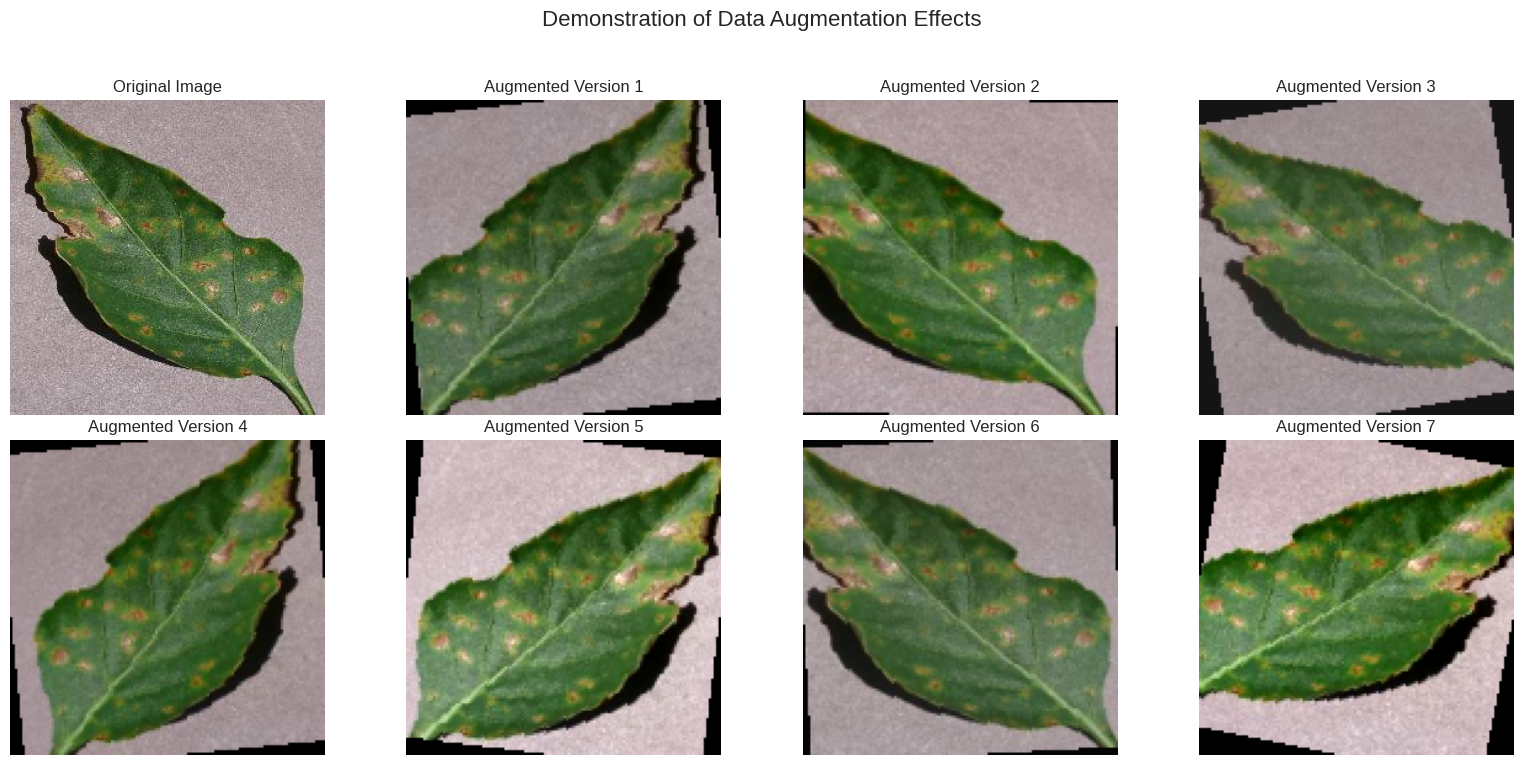

In [6]:
sample_image_path = sample_df.iloc[0]['filepath']
sample_image = Image.open(sample_image_path)

# Define the same augmentation pipeline used in training
augmentation_pipeline = T.Compose([
    T.RandomResizedCrop(128, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
])

# Generate and plot augmented versions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes[0, 0].imshow(sample_image)
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

for i in range(1, 8):
    ax = axes[i // 4, i % 4]
    aug_img = augmentation_pipeline(sample_image)
    ax.imshow(aug_img)
    ax.set_title(f'Augmented Version {i}')
    ax.axis('off')
plt.suptitle('Demonstration of Data Augmentation Effects', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('eda_augmentation_demo.png')
plt.show()

## Part 2: Prototypical Network Modeling Pipeline

**Objective:** Based on our EDA, we need a model that is robust to visual variations and computationally efficient. We will now implement our Prototypical Network from scratch.

**Pipeline:**
1.  **Model Architecture:** Define the custom CNN Encoder.
2.  **Data Handling:** Set up DataLoaders with the augmentation strategy justified by our EDA.
3.  **Training & Evaluation:** Implement the training loop with the custom prototypical loss and the validation logic.
4.  **Analysis:** Load the best-performing model to generate the final classification report and the interpretable prototype visualizations.

### 2.1 Model Architecture: The Encoder
The main part of our Prototypical Network is a custom Encoder, a light Convolutional Neural Network (CNN) designed and built entirely from scratch. Adhering to the competition's rules, we do not use any pre-trained architectures. The Encoder's sole purpose is not to classify, but to learn a rich feature representation by mapping each input image into a 64-dimensional embedding space.

Our architecture consists of four sequential convolutional blocks, which progressively increase in channel depth (32 → 256) to capture features of increasing complexity, from simple edges to intricate disease patterns. Each block utilizes standard Conv2d, ReLU, and BatchNorm2d layers to ensure stable and effective learning. Following the feature extraction, an AdaptiveAvgPool2d layer and a final linear projection head distill these features into the target embedding vector. The model summary below provides a transparent overview of this architecture, confirming its efficiency and low parameter count.

In [7]:
CONFIG = {
    "data_path": DATASET_PATH,
    "batch_size": 128,
    "learning_rate": 0.001,
    "num_epochs": 10,
    "split_ratios": [0.7, 0.15, 0.15],
    "image_size": 256,
    "embedding_dim": 64,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 42,
    "model_save_path": "plant_disease_prototypical_final.pth"
}

In [8]:
class Encoder(nn.Module):
    """
    A lightweight CNN that encodes an image into a low-dimensional vector space.
    This is the core of the Prototypical Network.
    """
    def __init__(self, embedding_dim):
        super(Encoder, self).__init__()
        self.features = nn.Sequential(
            # Block 1: 128 -> 64
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(32), nn.MaxPool2d(2),
            # Block 2: 64 -> 32
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2),
            # Block 3: 32 -> 16
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(128), nn.MaxPool2d(2),
            # Block 4: 16 -> 8
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(256), nn.MaxPool2d(2),
            # Final Pooling and Flattening
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )
        # projection head to map features to the target embedding dimension
        self.projection = nn.Linear(256, embedding_dim)

    def forward(self, x):
        return self.projection(self.features(x))

# display a summary of the model architecture and parameter count
summary(Encoder(CONFIG['embedding_dim']), input_size=(1, 3, CONFIG['image_size'], CONFIG['image_size']), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Encoder                                  [1, 3, 256, 256]          [1, 64]                   --
├─Sequential: 1-1                        [1, 3, 256, 256]          [1, 256]                  --
│    └─Conv2d: 2-1                       [1, 3, 256, 256]          [1, 32, 256, 256]         896
│    └─ReLU: 2-2                         [1, 32, 256, 256]         [1, 32, 256, 256]         --
│    └─BatchNorm2d: 2-3                  [1, 32, 256, 256]         [1, 32, 256, 256]         64
│    └─MaxPool2d: 2-4                    [1, 32, 256, 256]         [1, 32, 128, 128]         --
│    └─Conv2d: 2-5                       [1, 32, 128, 128]         [1, 64, 128, 128]         18,496
│    └─ReLU: 2-6                         [1, 64, 128, 128]         [1, 64, 128, 128]         --
│    └─BatchNorm2d: 2-7                  [1, 64, 128, 128]         [1, 64, 128, 128]         128
│    └─MaxPool2d: 2-8        

### 2.2 Data Handling and Preparation

#### Methodology:
In our data handling, we defined a PrototypicalDataset class that helped us process the dataset for our network. Its primary function is to **yield both the augmented tensor for model training and the original, untouched PIL image**, a critical design choice that enables us to visualize the model's learned prototypes later. Based on our EDA, which revealed significant variations in lighting, orientation, and background, we apply an aggressive augmentation pipeline, including RandomResizedCrop, RandomHorizontalFlip, RandomRotation, and ColorJitter, to the training data only. This strategy forces the model to learn the core pathological features of each disease rather than superficial artifacts. The dataset is then split into training (70%), validation (15%), and testing (15%) sets and loaded via PyTorch DataLoaders with a custom collate_fn to efficiently batch the (tensor, original_image, label) tuples for training and evaluation.

In [9]:
class PrototypicalDataset(Dataset):
    """
    A custom Dataset that wraps a subset and returns both the transformed tensor
    (for the model) and the original PIL image (for visualization).
    """
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        original_img, label = self.subset[index]
        transformed_tensor = self.transform(original_img) if self.transform else original_img
        return transformed_tensor, original_img, label

    def __len__(self):
        return len(self.subset)

def get_data_loaders(config):
    """
    Handles data loading, augmentation, and splitting into DataLoaders.
    """
    dataset_stats = ([0.4739, 0.4901, 0.4228], [0.2282, 0.2231, 0.2415]) # set initial stats

    # augmentation pipeline for the training set to improve model robustness
    train_transforms = T.Compose([
        T.RandomResizedCrop(config["image_size"], scale=(0.8, 1.0)),
        T.RandomHorizontalFlip(),
        T.RandomRotation(15),
        T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        T.ToTensor(),
        T.Normalize(*dataset_stats)
    ])

    # resizing and normalization for validation and test sets
    val_test_transforms = T.Compose([
        T.Resize(config["image_size"]),
        T.CenterCrop(config["image_size"]),
        T.ToTensor(),
        T.Normalize(*dataset_stats)
    ])

    full_dataset = datasets.ImageFolder(root=config["data_path"])
    torch.manual_seed(config["seed"])
    train_size = int(config["split_ratios"][0] * len(full_dataset))
    val_size = int(config["split_ratios"][1] * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size
    train_subset, val_subset, test_subset = random_split(full_dataset, [train_size, val_size, test_size])

    # Wrap subsets with our custom Dataset class
    train_proto_dataset = PrototypicalDataset(train_subset, transform=train_transforms)
    val_proto_dataset = PrototypicalDataset(val_subset, transform=val_test_transforms)
    test_proto_dataset = PrototypicalDataset(test_subset, transform=val_test_transforms)
    
    # collate function is needed to handle the (tensor, pil_image, label) tuples
    def collate_fn(batch):
        tensors, originals, labels = zip(*batch)
        return torch.stack(tensors, 0), originals, torch.tensor(labels)

    # create dataloaders
    train_loader = DataLoader(train_proto_dataset, batch_size=config["batch_size"], shuffle=True, num_workers=2, pin_memory=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_proto_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=2, pin_memory=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_proto_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=2, pin_memory=True, collate_fn=collate_fn)
    
    num_classes = len(full_dataset.classes)
    class_names = full_dataset.classes
    print(f"Data loaded: {len(train_subset)} train, {len(val_subset)} val, {len(test_subset)} test images.")
    return train_loader, val_loader, test_loader, num_classes, class_names


### 2.3 Training and Evaluation Logic
The model's intelligence is not derived from a standard classification layer, but from its unique **metric learning** process. We implement a custom Prototypical Loss function that operates dynamically within each training batch. For every batch, it calculates a temporary centroid for each class present and computes a loss based on the distance of each sample's embedding to these centroids. This process effectively pulls same-class embeddings into tight clusters while pushing dissimilar classes apart. The train_one_epoch function executes this iterative learning process.

For evaluation, a more stable approach is required. The calculate_global_prototypes function computes a single, definitive prototype for each class by averaging the embeddings of all samples in the entire training set. This global prototype then serves as the fixed reference point against which new images in the validation and test sets are compared for final classification.

In [10]:
def prototypical_loss(embeddings, labels, num_classes, device):
    """
    Calculates the prototypical loss and accuracy for a given batch.
    This loss encourages embeddings of the same class to cluster together.
    """
    prototypes = torch.zeros(num_classes, embeddings.size(1)).to(device)
    for c in range(num_classes):
        mask = (labels == c)
        if mask.sum() > 0:
            prototypes[c] = embeddings[mask].mean(0)
    
    dists = torch.cdist(embeddings, prototypes) ** 2
    log_p_y = nn.functional.log_softmax(-dists, dim=1)
    loss = -log_p_y.gather(1, labels.view(-1, 1)).squeeze().mean()
    _, preds = torch.min(dists, 1)
    acc = (preds == labels).float().mean()
    return loss, acc

def train_one_epoch(model, loader, optimizer, num_classes, device):
    """
    Performs a single epoch of training.
    """
    model.train()
    total_loss, total_acc = 0.0, 0.0
    progress_bar = tqdm(loader, desc="Training", leave=False)
    for tensors, _, labels in progress_bar: # Ignore original images during training
        tensors, labels = tensors.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(tensors)
        loss, acc = prototypical_loss(embeddings, labels, num_classes, device)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += acc.item()
        progress_bar.set_postfix(loss=loss.item(), acc=acc.item())
    return total_loss / len(loader), total_acc / len(loader)

def calculate_global_prototypes(model, loader, num_classes, embedding_dim, device):
    """
    Computes the single, average prototype for each class over the entire training set.
    """
    model.eval()
    all_embeddings = [[] for _ in range(num_classes)]
    with torch.no_grad():
        for tensors, _, labels in tqdm(loader, desc="Calculating Prototypes", leave=False):
            tensors = tensors.to(device)
            embeddings = model(tensors)
            for i, label in enumerate(labels):
                all_embeddings[label.item()].append(embeddings[i])
    
    prototypes = torch.zeros(num_classes, embedding_dim).to(device)
    for c in range(num_classes):
        if len(all_embeddings[c]) > 0:
            prototypes[c] = torch.stack(all_embeddings[c]).mean(0)
    return prototypes

### 2.4 Validation, Reporting, and Visualization
With the model trained, our methodology concludes with a rigorous two-part analysis. The validate function serves as our quantitative proof, evaluating the model's performance on unseen data by classifying embeddings based on their distance to the global prototypes. This function generates the final, detailed classification report, using Macro F1-Score as the primary metric for success. Complementing this, the plot_prototypes and plot_training_history functions provide the qualitative evidence. They are crucial for our claim in interpretability, as they visualize the model's stable learning curve and, most importantly, render the interpretable prototypes. This allows us to directly inspect the visual features the model has learned to define each class, making its internal logic transparent.

In [11]:
def validate(model, loader, prototypes, device, class_names=None, is_test=False):
    """
    Evaluates the model on a validation or test set by classifying
    based on the distance to the pre-computed global prototypes.
    """
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        desc = "Testing" if is_test else "Validating"
        for tensors, _, labels in tqdm(loader, desc=desc, leave=False):
            tensors = tensors.to(device)
            embeddings = model(tensors)
            dists = torch.cdist(embeddings, prototypes)
            preds = torch.argmin(dists, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    
    if is_test:
        print("\n--- Detailed Classification Report ---")
        print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
    return acc, f1

def plot_prototypes(model, train_loader, global_prototypes, class_names, device):
    """
    Finds and plots the single training image that is closest in embedding
    space to each calculated class prototype. This gives an honest view
    of what the model considers the "ideal" example for each class.
    """
    model.eval()
    num_classes = len(class_names)
    prototype_images = [None] * num_classes
    
    all_embeddings = [[] for _ in range(num_classes)]
    all_original_images = [[] for _ in range(num_classes)]

    print("\nEncoding all training images to find best representatives...")
    with torch.no_grad():
        for tensors, originals, labels in tqdm(train_loader, desc="Encoding"):
            tensors = tensors.to(device)
            embeddings = model(tensors)
            for i in range(len(labels)):
                label = labels[i].item()
                all_embeddings[label].append(embeddings[i].cpu())
                all_original_images[label].append(originals[i])

    print("Finding most representative image for each class prototype...")
    for c in range(num_classes):
        if not all_embeddings[c]:
            print(f"Warning: No training images found for class '{class_names[c]}'")
            continue
        
        class_embeddings = torch.stack(all_embeddings[c])
        dists = torch.norm(class_embeddings - global_prototypes[c].cpu(), dim=1)
        best_idx_in_class = torch.argmin(dists)
        prototype_images[c] = all_original_images[c][best_idx_in_class]

    # Plot the found prototype images
    fig, axes = plt.subplots(3, 5, figsize=(20, 12))
    fig.suptitle('Learned Prototypes for Each Class', fontsize=20)
    for i, proto_img in enumerate(prototype_images):
        ax = axes[i // 5, i % 5]
        if proto_img:
            ax.imshow(proto_img)
        ax.set_title(class_names[i].replace('_', ' ').title(), fontsize=10)
        ax.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('class_prototypes_honest.png')
    plt.show()

def plot_training_history(history):
    """
    Plots the training and validation metrics stored in the history dictionary.
    """
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle('Training and Validation History', fontsize=16)

    # Plot Loss
    ax1.plot(epochs, history['train_loss'], 'o-', label='Training Loss', color='royalblue')
    ax1.set_title('Loss per Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_xticks(epochs)

    # Plot Accuracy and F1-Score
    ax2.plot(epochs, history['train_acc'], 's-', label='Training Accuracy', color='forestgreen')
    ax2.plot(epochs, history['val_acc'], 's--', label='Validation Accuracy', color='limegreen')
    ax2.plot(epochs, history['val_f1'], '^-', label='Validation F1-Score', color='darkorange')
    ax2.set_title('Metrics per Epoch')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Score')
    ax2.legend()
    ax2.set_xticks(epochs)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('training_history.png')
    plt.show()


### 2.5 Main Execution
This part of the code runs all the code we've put together. It is controlled by a single RUN_TRAINING flag to provide a flexible workflow. When set to True, the script executes the complete end-to-end training process, saving the best-performing model based on validation F1-score at each epoch. Upon completion, it automatically proceeds to the analysis phase. When set to False, it bypasses the resource-intensive training, loads the previously saved best model, and jumps directly to the final evaluation and visualization. This dual-mode capability ensures both reproducibility of the training experiment and efficient generation of analytical results from a completed run.

Using device: CUDA
Data loaded: 14446 train, 3095 val, 3097 test images.

--- Starting Training ---

Epoch 1/10


Training:   0%|          | 0/113 [00:00<?, ?it/s]W0824 04:19:41.196000 19 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


Train Loss: 0.9281 | Train Acc: 0.7207
Val Acc:    0.6769 | Val F1:    0.6328
New best model saved with F1-Score: 0.6328

Epoch 2/10


Train Loss: 0.5177 | Train Acc: 0.8266
Val Acc:    0.7593 | Val F1:    0.7096
New best model saved with F1-Score: 0.7096

Epoch 3/10


Train Loss: 0.3610 | Train Acc: 0.8821
Val Acc:    0.7735 | Val F1:    0.7429
New best model saved with F1-Score: 0.7429

Epoch 4/10


Train Loss: 0.2853 | Train Acc: 0.9057
Val Acc:    0.8113 | Val F1:    0.7798
New best model saved with F1-Score: 0.7798

Epoch 5/10


Train Loss: 0.2236 | Train Acc: 0.9253
Val Acc:    0.8433 | Val F1:    0.8071
New best model saved with F1-Score: 0.8071

Epoch 6/10


Train Loss: 0.1872 | Train Acc: 0.9370
Val Acc:    0.8362 | Val F1:    0.8042

Epoch 7/10


Train Loss: 0.1665 | Train Acc: 0.9454
Val Acc:    0.8730 | Val F1:    0.8460
New best model saved with F1-Score: 0.8460

Epoch 8/10


Train Loss: 0.1429 | Train Acc: 0.9511
Val Acc:    0.8931 | Val F1:    0.8728
New best model saved with F1-Score: 0.8728

Epoch 9/10


Train Loss: 0.1350 | Train Acc: 0.9543
Val Acc:    0.8782 | Val F1:    0.8455

Epoch 10/10


Train Loss: 0.1176 | Train Acc: 0.9610
Val Acc:    0.8911 | Val F1:    0.8537

--- Training Finished ---

--- Generating Training History Plot ---


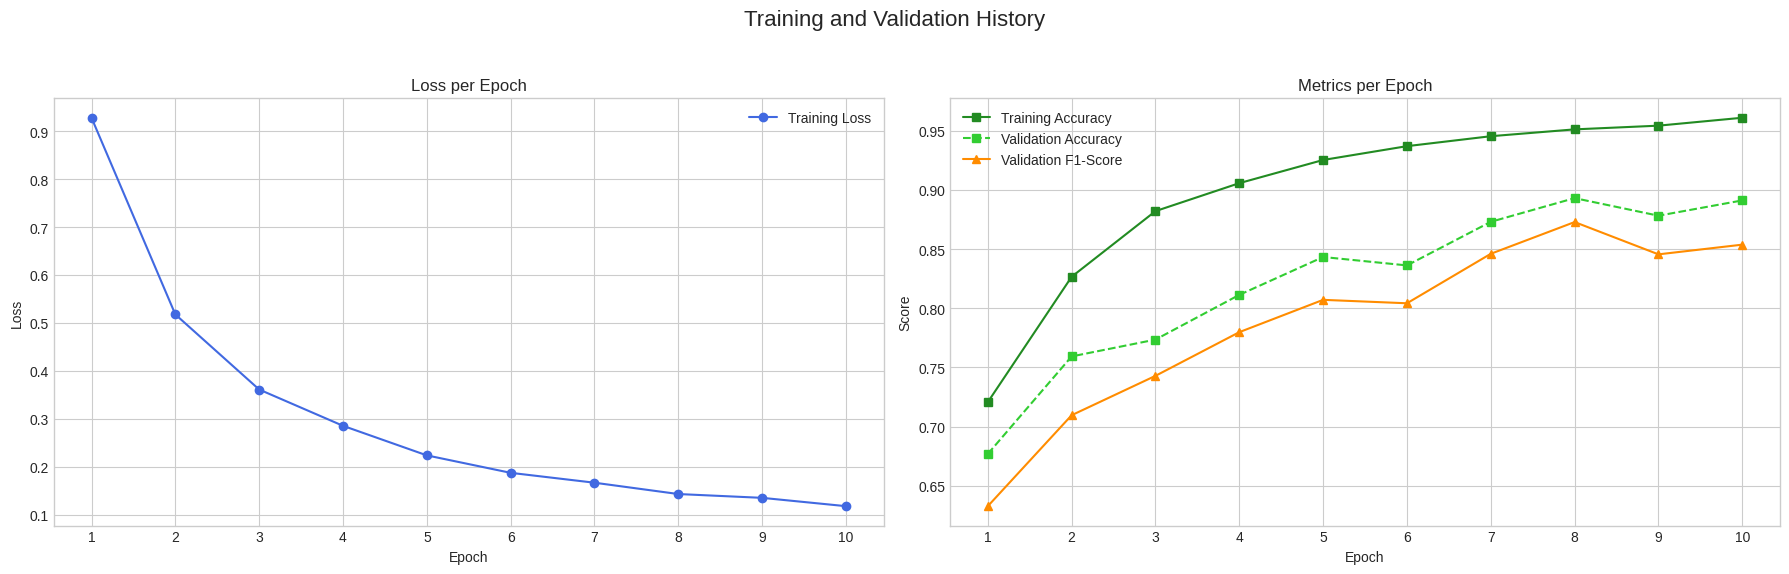


--- Starting Final Analysis Phase ---
Successfully loaded best model from plant_disease_prototypical_final.pth

--- Evaluating on Test Set with Best Model ---



--- Detailed Classification Report ---
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.96      0.94      0.95       140
                     Pepper__bell___healthy       0.98      0.96      0.97       241
                      Potato___Early_blight       0.93      0.96      0.95       156
                       Potato___Late_blight       0.92      0.80      0.86       168
                           Potato___healthy       0.73      0.86      0.79        22
                      Tomato_Bacterial_spot       0.98      0.95      0.97       335
                        Tomato_Early_blight       0.92      0.76      0.83       150
                         Tomato_Late_blight       0.91      0.84      0.87       274
                           Tomato_Leaf_Mold       0.82      0.96      0.88       139
                  Tomato_Septoria_leaf_spot       0.94      0.92      0.93       264
Tomato_Spider_mites_Two_

Encoding: 100%|██████████| 113/113 [01:04<00:00,  1.75it/s]


Finding most representative image for each class prototype...


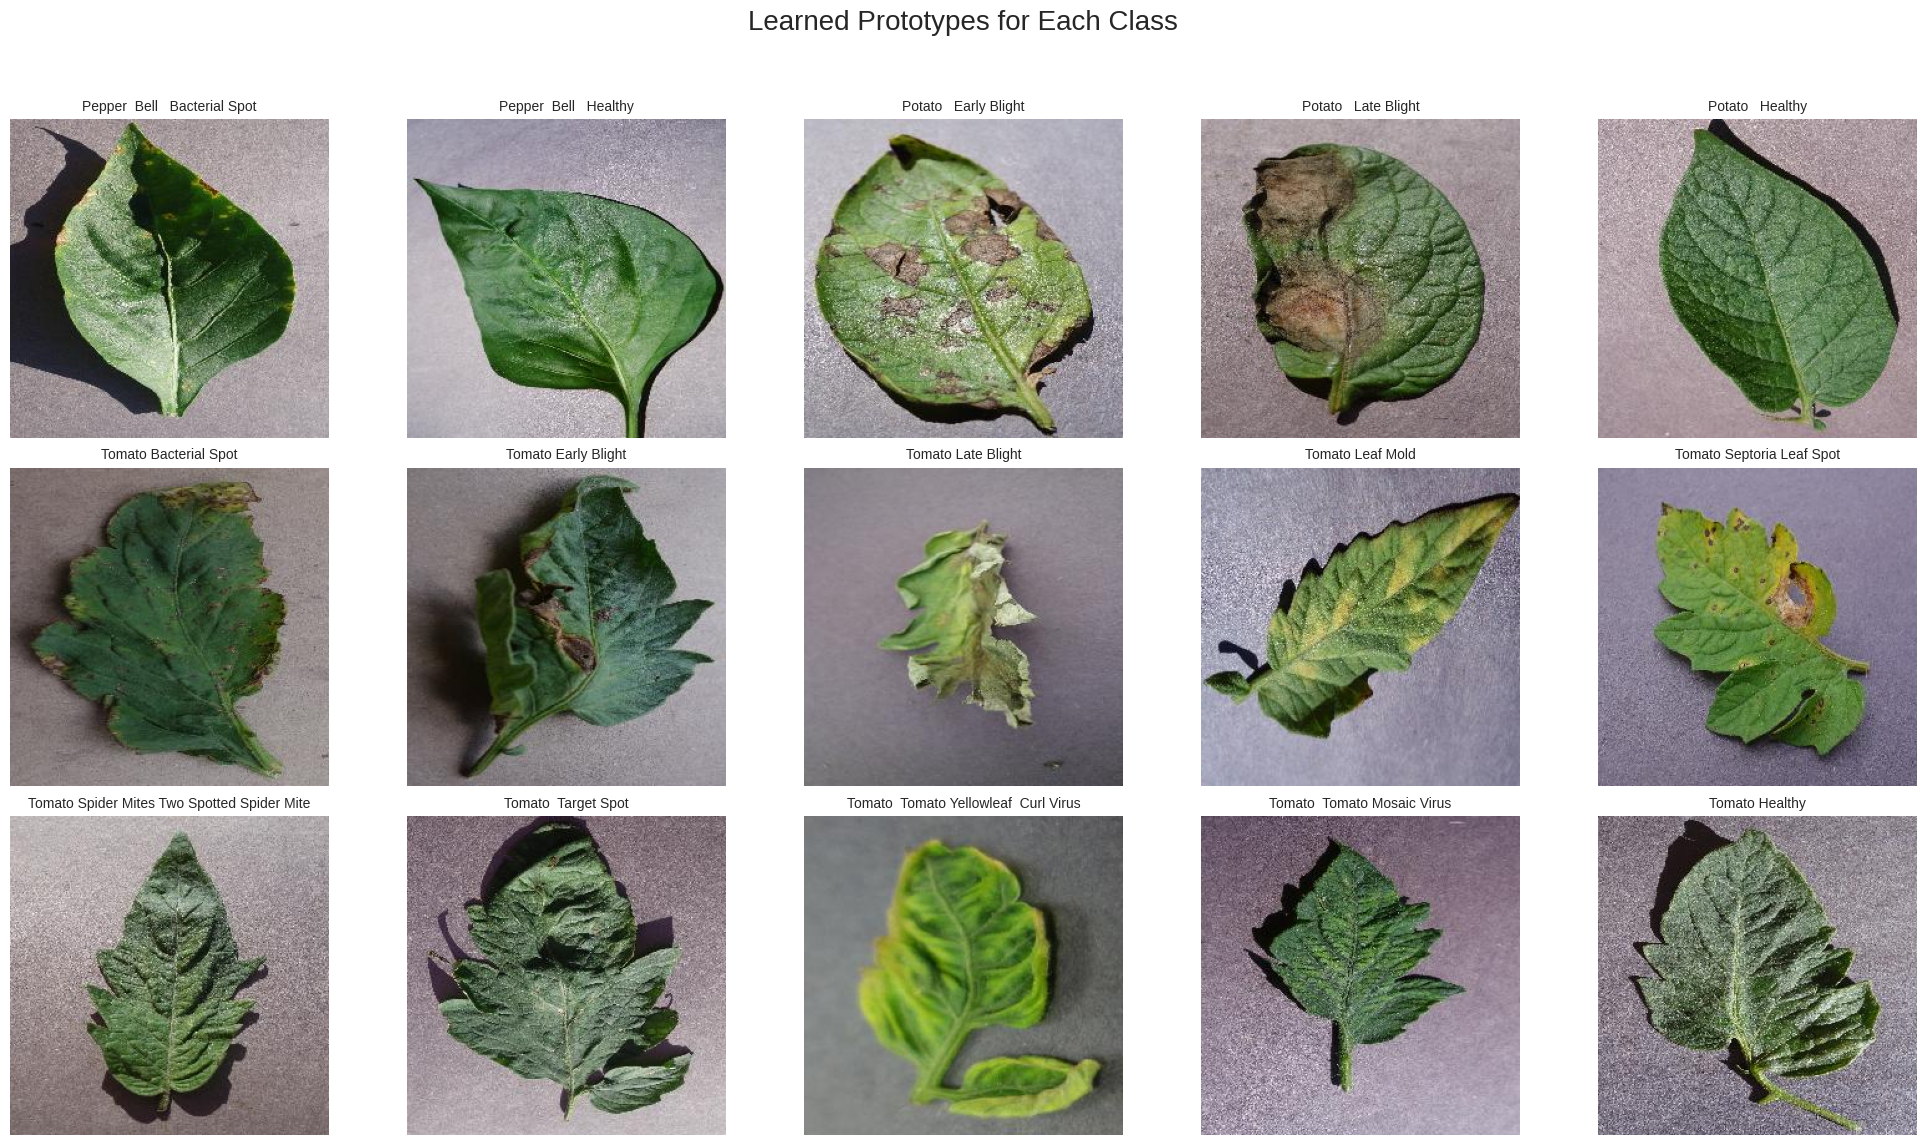

In [12]:
import sys
def main():
    # set flag to True to run training, or False to load a model and analyze.
    RUN_TRAINING = True

    print(f"Using device: {CONFIG['device'].upper()}")
    
    # load data structures
    train_loader, val_loader, test_loader, num_classes, class_names = get_data_loaders(CONFIG)
    
    # initialize model
    model = Encoder(CONFIG['embedding_dim']).to(CONFIG['device'])
    model = torch.compile(model)
    if RUN_TRAINING:
        print("\n--- Starting Training ---")
        optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])
        best_val_f1 = 0.0
        
        # initialize history tracking
        history = {'train_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1': []}
        for epoch in range(CONFIG['num_epochs']):
            print(f"\nEpoch {epoch + 1}/{CONFIG['num_epochs']}")
            train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, num_classes, CONFIG['device'])
            
            # for validation, we calculate prototypes on the fly from the training set
            global_prototypes = calculate_global_prototypes(model, train_loader, num_classes, CONFIG['embedding_dim'], CONFIG['device'])
            val_acc, val_f1 = validate(model, val_loader, global_prototypes, CONFIG['device'])
            
            print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
            print(f"Val Acc:    {val_acc:.4f} | Val F1:    {val_f1:.4f}")
            
            # store history
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_acc)
            history['val_f1'].append(val_f1)
            
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                torch.save(model.state_dict(), CONFIG['model_save_path'])
                print(f"New best model saved with F1-Score: {best_val_f1:.4f}")
        
        print(f"\n--- Training Finished ---")
        print("\n--- Generating Training History Plot ---")
        plot_training_history(history)

    # --- Analysis Phase (runs after training or if RUN_TRAINING is False) ---
    print("\n--- Starting Final Analysis Phase ---")
    try:
        # loads state of the best saved model for a fair final evaluation
        model.load_state_dict(torch.load(CONFIG['model_save_path']))
        print(f"Successfully loaded best model from {CONFIG['model_save_path']}")
    except FileNotFoundError:
        print(f"ERROR: Model file not found at {CONFIG['model_save_path']}.")
        print("Please ensure the model has been trained (set RUN_TRAINING to True) or the file exists.")
        exit()

    # 1. eval the final model on the unseen test set
    print("\n--- Evaluating on Test Set with Best Model ---")
    # Recalculate final prototypes using the loaded best model
    final_prototypes = calculate_global_prototypes(model, train_loader, num_classes, CONFIG['embedding_dim'], CONFIG['device'])
    test_acc, test_f1 = validate(model, test_loader, final_prototypes, CONFIG['device'], class_names=class_names, is_test=True)
    
    # 2. generate and plot the interpretable class prototypes
    print("\n--- Generating Interpretable Prototypes ---")
    plot_prototypes(model, train_loader, final_prototypes, class_names, CONFIG['device'])

main()